# Experiment 2: 2D regression

In [40]:
import numpy as np
import tensorflow as tf
from scipy.stats import truncnorm

In [41]:
class MetaDataset:
    def __init__(self, random_state=None):
        if random_state is None:
            self.random_state = np.random
        else:
            self.random_state = random_state

    def generate_meta_train_data(self, n_tasks: int, n_samples: int) -> list:
        raise NotImplementedError

    def generate_meta_test_data(self, n_tasks: int, n_samples_context: int, n_samples_test: int) -> list:
        raise NotImplementedError

In [307]:
class CauchyMetaDataset(MetaDataset):

    def __init__(self, noise_std=0.05, ndim_x=2, random_state=None):
        self.noise_std = noise_std
        self.ndim_x = ndim_x
        super().__init__(random_state)

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            X = truncnorm.rvs(-3, 2, loc=0, scale=2.5, size=(n_samples, self.ndim_x), 
                              random_state=self.random_state)
            Y = self._gp_fun_from_prior(X)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            X = truncnorm.rvs(-3, 2, loc=0, scale=2.5, size=(n_samples_context + n_samples_test, self.ndim_x),
                              random_state=self.random_state)
            Y = self._gp_fun_from_prior(X)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples

    def _mean(self, x):
        loc1 = -1 * np.ones(x.shape[-1])
        loc2 = 2 * np.ones(x.shape[-1])
        cauchy1 = 1 / (np.pi * (1 + (np.linalg.norm(x - loc1, axis=-1)) ** 2))
        cauchy2 = 1 / (np.pi * (1 + (np.linalg.norm(x - loc2, axis=-1)) ** 2))
        return 6 * cauchy1 + 3 * cauchy2 + 1

    def _gp_fun_from_prior(self, X):
        assert X.ndim == 2

        n = X.shape[0]

        def kernel(a, b, lengthscale):
            sqdist = np.sum(a ** 2, 1).reshape(-1, 1) + np.sum(b ** 2, 1) - 2 * np.dot(a, b.T)
            return np.exp(-.5 * (1 / lengthscale) * sqdist)

        K_ss = kernel(X, X, 0.5)
        L = np.linalg.cholesky(K_ss + 1e-8 * np.eye(n))
        f = self._mean(X) + np.dot(L, self.random_state.normal(scale=0.2, size=(n, 1))).flatten()
        y = f + self.random_state.normal(scale=self.noise_std, size=f.shape)
        return y.reshape(-1, 1)

In [325]:
def provide_data(dataset, seed=28, n_train_tasks=None, n_samples=None, config=None):
    import numpy as np

    N_TEST_TASKS = 20
    N_VALID_TASKS = 20
    N_TEST_SAMPLES = 200

    # if specified, overwrite default settings
    if config is not None:
        if config['num_test_valid_tasks'] is not None: N_TEST_TASKS = config['num_test_valid_tasks']
        if config['num_test_valid_tasks'] is not None: N_VALID_TASKS = config['num_test_valid_tasks']
        if config['num_test_valid_samples'] is not None:  N_TEST_SAMPLES = config['num_test_valid_samples']
            
            
    elif 'cauchy' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = CauchyMetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    elif 'sinc' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = Sinc_MetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    elif 'movingsinc' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = moving_Sinc_MetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    else:
        raise NotImplementedError('Does not recognize dataset flag')

    data_train = dataset.generate_meta_train_data(n_tasks=n_train_tasks, n_samples=n_train_samples)

    data_test_valid = dataset.generate_meta_test_data(n_tasks=N_TEST_TASKS + N_VALID_TASKS,
                                                      n_samples_context=n_context_samples,
                                                      n_samples_test=N_TEST_SAMPLES)
    data_valid = data_test_valid[N_VALID_TASKS:]
    data_test = data_test_valid[:N_VALID_TASKS]

    return data_train, data_valid, data_test

20
200


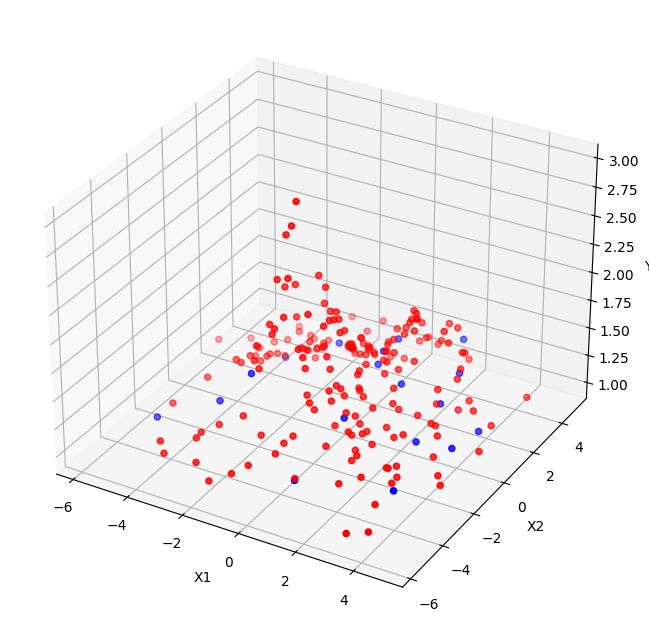

In [306]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meta_train_data, meta_test_data, _ = provide_data(dataset='cauchy_20')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for i in range(1):
    X_context, Y_context, X_test, Y_test = meta_test_data[i]
    print(len(Y_context))
    print(len(Y_test))
    ax.scatter(X_context[:, 0], X_context[:, 1], Y_context, c='b', marker='o')
    ax.scatter(X_test[:, 0], X_test[:, 1], Y_test, c='r', marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

plt.show()

In [5]:
tf.get_logger().setLevel('ERROR')

from pacoh_nn.datasets.regression_datasets import provide_data

meta_train_data, meta_test_data, _ = provide_data(dataset='cauchy_20')

from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, prior_weight=0.184, bandwidth=480.,
                                  hyper_prior_likelihood_log_var_mean_mean=-1.0,
                                  hyper_prior_log_var_mean=-1.74, hyper_prior_nn_std=0.12,
                                  hyper_prior_weight=1e-5, lr=1.5e-3, learn_likelihood=True,
                                  random_seed=28, num_iter_meta_train=20000)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=10000, log_period=1000, plot_period=5000)

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f" % (key, eval_metrics_mean[key], eval_metrics_std[key]))


2023-04-23 11:09:20.405632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	 [[{{node Placeholder/_0}}]]
2023-04-23 11:09:20.473927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	 [[{{node Placeholder/_0}}]]
2023-04-23 11:09:20.491682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	

Start meta-training -------------------- 


2023-04-23 11:09:35.863917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]



Iter 0/20000 - Time 32.67 sec - Train-Loss: -4756.78271

Iter 1000/20000 - Time 18.83 sec - Train-Loss: -289.23868

Iter 2000/20000 - Time 18.63 sec - Train-Loss: -300.20395

Iter 3000/20000 - Time 18.61 sec - Train-Loss: -394.19202

Iter 4000/20000 - Time 19.48 sec - Train-Loss: -263.97458

Iter 5000/20000 - Time 20.29 sec - Train-Loss: -241.33879

Iter 6000/20000 - Time 23.28 sec - Train-Loss: -161.31827

Iter 7000/20000 - Time 19.93 sec - Train-Loss: -116.62862

Iter 8000/20000 - Time 19.56 sec - Train-Loss: -40.26481

Iter 9000/20000 - Time 17.99 sec - Train-Loss: -19.29708


2023-04-23 11:13:14.732572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 11:13:14.742593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 11:13:14.752622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----


2023-04-23 11:13:23.189538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 11:13:23.231932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16}}]]
2023-04-23 11:13:23.330667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this

	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 18.83 sec - Train-Loss: -13.78994- Val-cal_err: 0.056 +- 0.020- Val-avg_ll: 0.100 +- 0.131- Val-avg_rmse: 0.203 +- 0.017

Iter 11000/20000 - Time 27.95 sec - Train-Loss: -13.01157

Iter 12000/20000 - Time 22.01 sec - Train-Loss: -11.15002

Iter 13000/20000 - Time 22.31 sec - Train-Loss: -8.44897

Iter 14000/20000 - Time 20.08 sec - Train-Loss: -8.89291

Iter 15000/20000 - Time 19.36 sec - Train-Loss: -6.90771

Iter 16000/20000 - Time 22.49 sec - Train-Loss: -5.96297

Iter 17000/20000 - Time 22.22 sec - Train-Loss: -6.00159

Iter 18000/20000 - Time 19.15 sec - Train-Loss: -4.90483

Iter 19000/20000 - Time 21.39 sec - Train-Loss: -4.88655


2023-04-23 11:21:20.343796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 11:21:20.353568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 11:21:20.364254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


2023-04-23 11:21:20.553468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 11:21:20.560987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 11:21:20.569494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
cal_err: 0.0470 +- 0.0238
avg_ll: 0.1664 +- 0.0837
avg_rmse: 0.2063 +- 0.0179


# 2D Sinc function Regression

In [313]:
from pylab import figure, cm

import matplotlib.pyplot as plt
import numpy as np

def f(x1,x2):
    return x1 * np.exp(-(x1**2+x2**2))

def f_2(x1,x2):
    return np.exp(-(x1**2+x2**2)**0.5) * (x1**2+x2**2)**0.5

def f2(x1, x2):
    return np.arctan(x1, x2)

def sinc_2D(x1, x2):
    return np.sin(np.sqrt(x1**2 + x2**2))/np.sqrt(x1**2 + x2**2)


x1_min = -10.0
x1_max = 10.0
x2_min = -10.0
x2_max = 10.0

x1, x2 = np.linspace(x1_min, x1_max, 300), np.linspace(x2_min, x2_max, 300)


X1, X2 = np.meshgrid(x1, x2)

y = sinc_2D(X1-2, X2-2) + 2*sinc_2D(X1 +1, X2 +3)

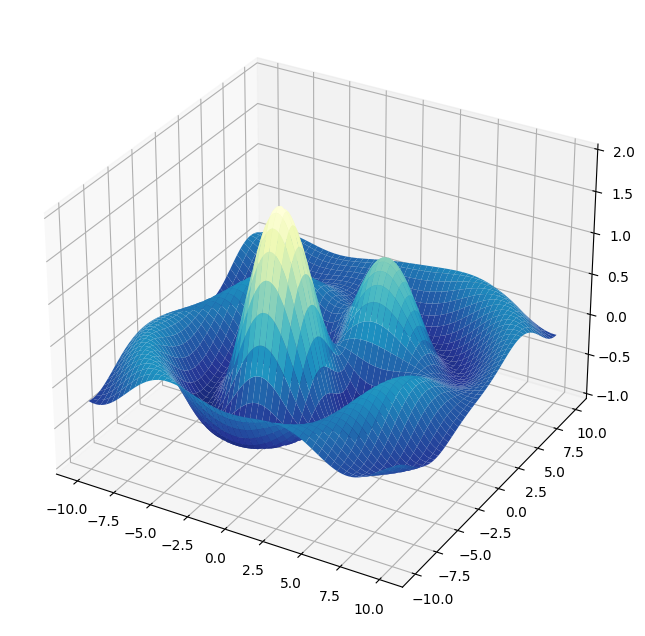

In [314]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot( projection='3d')


# Plot the surface.
ax.plot_surface(X1, X2, y, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_zlim(-1, 2)
plt.show()

In [316]:
class Sinc_MetaDataset(MetaDataset):
#class CauchyMetaDataset():

    def __init__(self, noise_std=0.05, ndim_x=2, random_state=None):
        self.noise_std = noise_std
        self.ndim_x = ndim_x
        super().__init__(random_state)

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            X = truncnorm.rvs(-10, 10, loc=0, scale=2.5, size=(n_samples, self.ndim_x), 
                              random_state=self.random_state)
            Y = self._gp_fun_from_prior(X)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            X = truncnorm.rvs(-10, 10, loc=0, scale=2.5, size=(n_samples_context + n_samples_test, self.ndim_x),
                              random_state=self.random_state)
            Y = self._gp_fun_from_prior(X)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples
    
    def sinc_mean(self, x):
        loc1 = [-2 , -2]
        loc2 = [1, 3]
        sinc1 = np.sin(np.linalg.norm(x - loc1, axis=-1))/np.linalg.norm(x - loc1, axis=-1)
        sinc2 = np.sin(np.linalg.norm(x - loc2, axis=-1))/np.linalg.norm(x - loc2, axis=-1)
        return sinc1 + 2 * sinc2

    def _gp_fun_from_prior(self, X):
        assert X.ndim == 2

        n = X.shape[0]

        def kernel(a, b, lengthscale):
            sqdist = np.sum(a ** 2, 1).reshape(-1, 1) + np.sum(b ** 2, 1) - 2 * np.dot(a, b.T)
            return np.exp(-.5 * (1 / lengthscale) * sqdist)

        K_ss = kernel(X, X, 0.5)
        L = np.linalg.cholesky(K_ss + 1e-8 * np.eye(n))
        f = self.sinc_mean(X) + np.dot(L, self.random_state.normal(scale=0.2, size=(n, 1))).flatten()
        y = f + self.random_state.normal(scale=self.noise_std, size=f.shape)
        return y.reshape(-1, 1)

1000
200


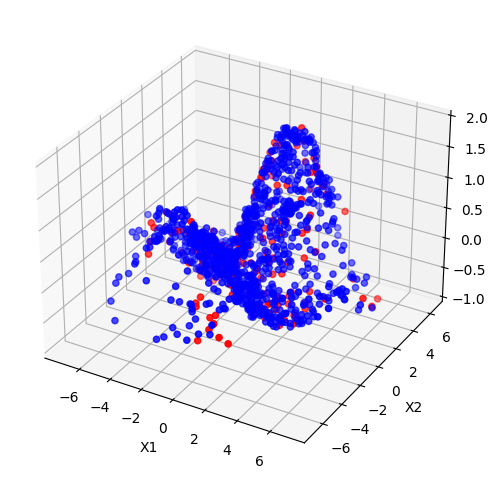

In [317]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meta_train_data, meta_test_data, _ = provide_data(dataset='sinc_20', n_samples=1000)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(1):
    X_context, Y_context, X_test, Y_test = meta_test_data[i]
    print(len(Y_context))
    print(len(Y_test))
    ax.scatter(X_context[:, 0], X_context[:, 1], Y_context, c='b', marker='o')
    ax.scatter(X_test[:, 0], X_test[:, 1], Y_test, c='r', marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

plt.show()

## PACOH-NN

In [323]:
tf.get_logger().setLevel('ERROR')

from pacoh_nn.datasets.regression_datasets import provide_data

#choose number of tasks here
meta_train_data, meta_test_data, _ = provide_data(dataset='sinc_20', n_train_tasks=1, n_samples=20)

from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, prior_weight=0.184, bandwidth=480.,
                                  hyper_prior_likelihood_log_var_mean_mean=-1.0,
                                  hyper_prior_log_var_mean=-1.74, hyper_prior_nn_std=0.12,
                                  hyper_prior_weight=1e-5, lr=1.5e-3, learn_likelihood=True,
                                  random_seed=28, num_iter_meta_train=20000)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=10000, log_period=1000, plot_period=5000)

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f" % (key, eval_metrics_mean[key], eval_metrics_std[key]))


2023-04-23 20:27:08.077931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 20:27:08.144706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,1]
	 [[{{node Placeholder/_0}}]]
2023-04-23 20:27:08.162011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,1]
	

Start meta-training -------------------- 


2023-04-23 20:27:24.268886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]



Iter 0/20000 - Time 32.94 sec - Train-Loss: -6782.31885

Iter 1000/20000 - Time 19.42 sec - Train-Loss: -312.11377

Iter 2000/20000 - Time 21.72 sec - Train-Loss: -280.39377

Iter 3000/20000 - Time 21.80 sec - Train-Loss: -452.42395

Iter 4000/20000 - Time 22.27 sec - Train-Loss: -204.72224

Iter 5000/20000 - Time 19.80 sec - Train-Loss: -160.14937

Iter 6000/20000 - Time 20.84 sec - Train-Loss: -86.42417

Iter 7000/20000 - Time 20.83 sec - Train-Loss: -47.76489

Iter 8000/20000 - Time 19.56 sec - Train-Loss: -18.33136

Iter 9000/20000 - Time 20.08 sec - Train-Loss: -11.48915


2023-04-23 20:31:16.010374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 20:31:16.021705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,1]
	 [[{{node Placeholder/_0}}]]
2023-04-23 20:31:16.037522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----


2023-04-23 20:31:25.925497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 20:31:25.973435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16}}]]
2023-04-23 20:31:26.077121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this

	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 20.85 sec - Train-Loss: -11.68413- Val-cal_err: 0.073 +- 0.026- Val-avg_ll: -0.300 +- 0.094- Val-avg_rmse: 0.296 +- 0.043

Iter 11000/20000 - Time 29.32 sec - Train-Loss: -9.48329

Iter 12000/20000 - Time 20.09 sec - Train-Loss: -10.38340

Iter 13000/20000 - Time 19.24 sec - Train-Loss: -6.92785

Iter 14000/20000 - Time 21.42 sec - Train-Loss: -6.13074

Iter 15000/20000 - Time 18.89 sec - Train-Loss: -4.77738

Iter 16000/20000 - Time 24.68 sec - Train-Loss: -4.21032

Iter 17000/20000 - Time 19.99 sec - Train-Loss: -5.61658

Iter 18000/20000 - Time 18.86 sec - Train-Loss: -3.88644

Iter 19000/20000 - Time 22.63 sec - Train-Loss: -2.57958


2023-04-23 20:39:16.058854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 20:39:16.072943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-23 20:39:16.081901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


2023-04-23 20:39:16.484552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [20]
	 [[{{node Placeholder/_0}}]]


	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
cal_err: 0.1376 +- 0.0158
avg_ll: -0.2160 +- 0.0452
avg_rmse: 0.2020 +- 0.0364


# 2D Sinc Function regression varying Sinc means

In [380]:
class moving_Sinc_MetaDataset(MetaDataset):
#class CauchyMetaDataset():

    def __init__(self, noise_std=0.05, ndim_x=2, random_state=None):
        self.noise_std = noise_std
        self.ndim_x = ndim_x
        super().__init__(random_state)

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            X = truncnorm.rvs(-10, 10, loc=0, scale=2.5, size=(n_samples, self.ndim_x))
            Y = self._gp_fun_from_prior(X)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            X = truncnorm.rvs(-10, 10, loc=0, scale=2.5, size=(n_samples_context + n_samples_test, self.ndim_x))
            Y = self._gp_fun_from_prior(X)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples
    
    def sinc_mean(self, x):
        loc1, loc2 = truncnorm.rvs(-10, 10, loc=0, scale=2.5, size=(2, self.ndim_x))
        sinc1 = np.sin(np.linalg.norm(x - loc1, axis=-1))/np.linalg.norm(x - loc1, axis=-1)
        sinc2 = np.sin(np.linalg.norm(x - loc2, axis=-1))/np.linalg.norm(x - loc2, axis=-1)
        return sinc1 + 2 * sinc2

    def _gp_fun_from_prior(self, X):
        assert X.ndim == 2

        n = X.shape[0]

        def kernel(a, b, lengthscale):
            sqdist = np.sum(a ** 2, 1).reshape(-1, 1) + np.sum(b ** 2, 1) - 2 * np.dot(a, b.T)
            return np.exp(-.5 * (1 / lengthscale) * sqdist)

        K_ss = kernel(X, X, 0.5)
        L = np.linalg.cholesky(K_ss + 1e-8 * np.eye(n))
        f = self.sinc_mean(X) + np.dot(L, self.random_state.normal(scale=0.2, size=(n, 1))).flatten()
        y = f + self.random_state.normal(scale=self.noise_std, size=f.shape)
        return y.reshape(-1, 1)

1000
200
1000
200


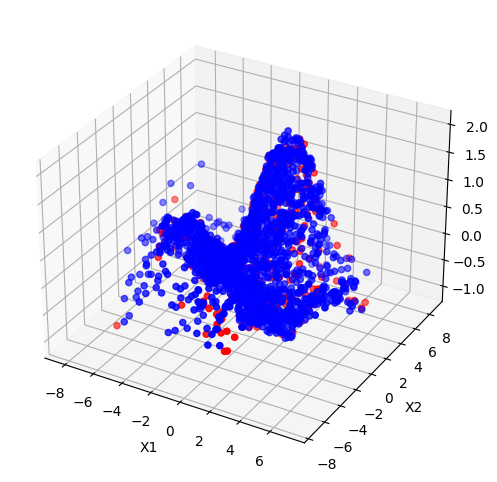

In [384]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meta_train_data, meta_test_data, _ = provide_data(dataset='movingsinc_20', n_samples=1000)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(2):
    X_context, Y_context, X_test, Y_test = meta_test_data[i]
    print(len(Y_context))
    print(len(Y_test))
    ax.scatter(X_context[:, 0], X_context[:, 1], Y_context, c='b', marker='o')
    ax.scatter(X_test[:, 0], X_test[:, 1], Y_test, c='r', marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

plt.show()

In [423]:
from pylab import figure, cm

import matplotlib.pyplot as plt
import numpy as np

def sinc_2D(x1, x2):
    return np.sin(np.sqrt(x1**2 + x2**2))/np.sqrt(x1**2 + x2**2)


x1_min = -5.0
x1_max = 5.0
x2_min = -5.0
x2_max = 5.0

x1, x2 = np.linspace(x1_min, x1_max, 300), np.linspace(x2_min, x2_max, 300)


X1, X2 = np.meshgrid(x1, x2)

loc1, loc2 = truncnorm.rvs(-10, 10, loc=0, scale=2.5, size=(2, 2))

y = sinc_2D(X1-loc1[0], X2-loc1[1]) + 1.5*sinc_2D(X1-loc2[0], X2-loc2[1])

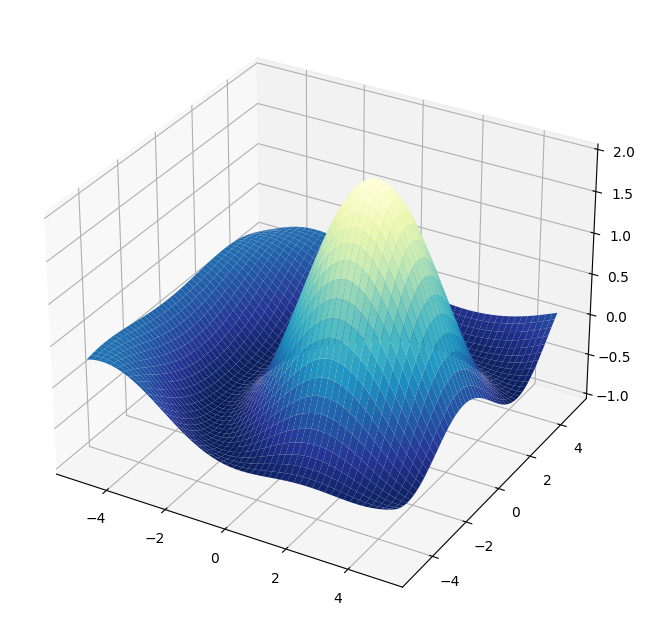

In [424]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot( projection='3d')


# Plot the surface.
ax.plot_surface(X1, X2, y, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_zlim(-1, 2)
plt.show()

In [398]:
def sinc_mean(x, mu1, mu2):
    #loc1, loc2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=2.5, size=(2, self.ndim_x))
    sinc1 = np.sin(np.linalg.norm(x - mu1, axis=-1))/np.linalg.norm(x - mu1, axis=-1)
    sinc2 = np.sin(np.linalg.norm(x - mu2, axis=-1))/np.linalg.norm(x - mu2, axis=-1)
    return sinc1 + 2 * sinc2


def gp_fun_from_prior(X, mu1, mu2):
    assert X.ndim == 2

    n = X.shape[0]

    def kernel(a, b, lengthscale):
        sqdist = np.sum(a ** 2, 1).reshape(-1, 1) + np.sum(b ** 2, 1) - 2 * np.dot(a, b.T)
        return np.exp(-.5 * (1 / lengthscale) * sqdist)
    noise_std = 0.1
    K_ss = kernel(X, X, 0.5)
    L = np.linalg.cholesky(K_ss + 1e-8 * np.eye(n))
    f = sinc_mean(X, mu1, mu2) #+ np.dot(L, self.random_state.normal(scale=0.2, size=(n, 1))).flatten()
    y = f + np.random.normal(scale=noise_std, size=f.shape)
    return y.reshape(-1, 1)

In [400]:
n_samples = 100
x_low, x_high = -10, 10

mu1, mu2 = truncnorm.rvs(x_low, x_high, loc=0, scale=2.5, size=(2, 2))
X = np.random.uniform(x_low, x_high, size=(n_samples, 2))
Y = gp_fun_from_prior(X, mu1, mu2)

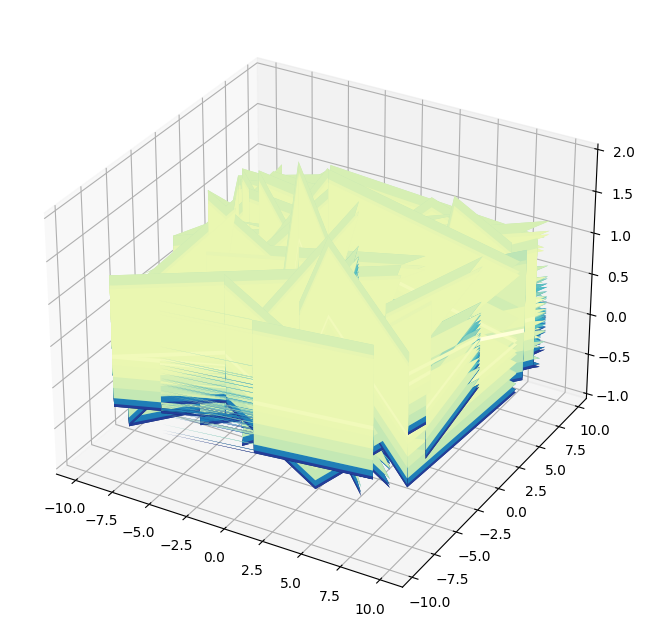

In [414]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot( projection='3d')

X = X.reshape(-1, 2)

# Get the x1 and x2 coordinates separately.
X1 = X[:, 0]
X2 = X[:, 1]

#print(X)

# Plot the surface.
ax.plot_surface(X1, X2, Y, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_zlim(-1, 2)
plt.show()